# Burst InSAR

## 1. Setup

Follow the developer setup instructions in the [HyP3-ISCE2 readme](https://github.com/asfhyp3/hyp3-isce2#developer-setup), then run the command below:

```bash
mamba activate hyp3-isce2
mamba install -y jupyter jupyterlab hyp3_sdk
```

## 2. Perform InSAR via the HyP3-ISCE2 package

In [ ]:
mkdir data

In [ ]:
cd data

In [ ]:
!python -m hyp3_isce2 ++process insar_tops_burst \
  S1_136231_IW2_20200604T022312_VV_7C85-BURST \
  S1_136231_IW2_20200616T022313_VV_5D11-BURST \
  --looks 20x4

## 3. Request Burst InSAR Processing via HyP3

In [ ]:
import copy
import hyp3_sdk as sdk
job_definition = {
    'job_parameters': {
        "granules": [
            "S1_136231_IW2_20200604T022312_VV_7C85-BURST",
            "S1_136231_IW2_20200616T022313_VV_5D11-BURST"
        ],
        "looks": "20x4"
    },
    "job_type": "INSAR_ISCE_BURST",
    "name": "UWG_BURST"
}
hyp3 = sdk.HyP3(api_url='https://hyp3-enterprise-test.asf.alaska.edu', prompt=True)

In [ ]:
jobs = sdk.Batch()
job = copy.deepcopy(job_definition)
jobs += hyp3.submit_prepared_jobs(job)

In [ ]:
jobs = hyp3.watch(jobs)

# 4. Plot the Unwrapped Interferogram

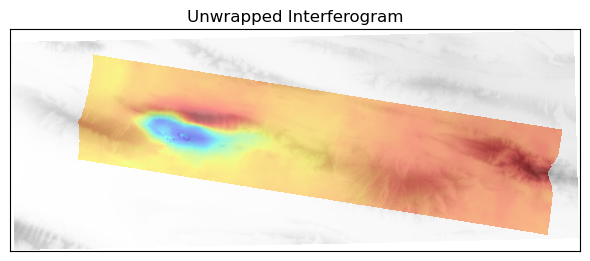

In [18]:
%matplotlib inline
import numpy as np
from pathlib import Path
from osgeo import gdal
import matplotlib
import matplotlib.pyplot as plt

product_name = 'S1_136231_IW2_20200604T022312_VV_7C85-BURSTxS1_136231_IW2_20200616T022313_VV_5D11-BURST'

unwrapped_file = Path(product_name) / f'{product_name}_unw_phase.tif'
dem_file = Path(product_name) / f'{product_name}_dem.tif'

ds = gdal.Open(str(unwrapped_file))
unwrapped = np.ma.masked_equal(ds.GetRasterBand(1).ReadAsArray(), 0)
del ds

ds = gdal.Open(str(dem_file))
dem = np.ma.masked_equal(ds.GetRasterBand(1).ReadAsArray(), 0)
del ds

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(unwrapped, alpha=0.75, cmap='jet')
ax.imshow(dem, alpha=0.4, cmap='Greys')
ax.set_title('Unwrapped Interferogram')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()